In [133]:
from glob import glob
import os
from pathlib import Path
import matplotlib.pyplot as plt
import re
from enum import Enum
import json
import pandas as pd
import seaborn as sns

# Data Loader

In [134]:
DEPS_SYNTHESIS_PATH = '../experiments/synthesis/depsynt'
PLAIN_SYNTHESIS_PATH = '../experiments/synthesis/spot-modular/'
SPOT_SD_SYNTHESIS_PATH = '../experiments/synthesis/spot-sd-no-decomposed/'
SPOT_SD_DECOMPOSED_SYNTHESIS_PATH = '../experiments/synthesis/spot-sd-decomposed/'
DEPS_SYNTHESIS_MODEL_CHECKING_PATH = '../experiments/model-checking/deps-synt'

In [135]:
class Status(Enum):
    ERROR = "Error"
    SUCCESS = "Success"
    NOT_FOUND = "Not Found"
    TIMEOUT = "Timeout"
    
    def __repr__(self):
        return str(self.value)
    
    def __str__(self):
        return str(self.value)

In [136]:
def get_all_benchmarks(path):
    hoa_files = glob(os.path.join(path, "*.hoa"))
    names = [
        Path(f).stem
        for f in hoa_files
    ]
    return names

print("Total benchmark with Deps Synthesis" , len(get_all_benchmarks(DEPS_SYNTHESIS_PATH)))
print("Total benchmark with Plain Synthesis" , len(get_all_benchmarks(PLAIN_SYNTHESIS_PATH)))
print("Total benchmark with Spot SD" , len(get_all_benchmarks(SPOT_SD_SYNTHESIS_PATH)))
print("Total benchmark with Spot SD (Decomposed)" , len(get_all_benchmarks(SPOT_SD_DECOMPOSED_SYNTHESIS_PATH)))
print("Total benchmark with Deps Synthesis + Model Checking" , len(get_all_benchmarks(DEPS_SYNTHESIS_MODEL_CHECKING_PATH)))

Total benchmark with Deps Synthesis 564
Total benchmark with Plain Synthesis 564
Total benchmark with Spot SD 564
Total benchmark with Spot SD (Decomposed) 564
Total benchmark with Deps Synthesis + Model Checking 564


In [137]:
def extract_vars_from_str(x):
    if len(x) == 0:
        return []
    return x.split(",")

In [138]:
def get_benchmark_name(idx):
    path = "../tools/scripts/benchmarks/{}.txt".format(idx)
    with open(path, 'r') as file:
        name = file.readline().replace("\n", "")
    return name
print(get_benchmark_name(2))

EnemeyModule


In [139]:
def benchmark_loader(path: str, idx: str):
    base = {
        'id': idx,
        'Name': get_benchmark_name(idx),
    }
    
    hoa_path = os.path.join(path, idx + ".hoa")
    json_path = os.path.join(path, idx + ".json")
    
    if not os.path.exists(hoa_path):
        return {
            **base,
            'Status': Status.NOT_FOUND
        }

    with open(hoa_path, 'r') as f:
        hoa_content = f.readlines()
        all_hoa_content = "\n".join(hoa_content)
        if 'DUE TO TIME LIMIT' in all_hoa_content:
            return {
                **base,
                'Status': Status.TIMEOUT,
            }

        if "Runtime error" in all_hoa_content or "Error occurred" in all_hoa_content or "Unknown failure" in all_hoa_content:
            return {
                **base,
                'Status': Status.ERROR,
                'Error': all_hoa_content
            }

    if not os.path.exists(json_path):
        return {
            **base,
            'Status': Status.ERROR,
            'Error': "\n".join(hoa_content)
        }
    
    with open(json_path, 'r') as f:
        content = "\r\n".join(f.readlines())
        try:
            benchmark_json = json.loads(content)
        except Exception as e:
            return {
                **base,
                'Status': Status.ERROR,
                'Error': content
            }

    # Generic Benchmark Name
    is_completed = benchmark_json['is_completed']
    total_time = benchmark_json['total_time']
    output_vars = benchmark_json['output_vars']
    input_vars = benchmark_json['input_vars']
    is_automaton_built = benchmark_json['automaton']['is_built']
    automaton_build_duration = benchmark_json['automaton'].get('build_duration', None)
    total_states = benchmark_json['automaton'].get('total_states', None)
    total_edges = benchmark_json['automaton'].get('total_edges', None)
    total_output_vars = len(benchmark_json['output_vars'])
    skipped_dependency = benchmark_json['dependency']['skipped_dependencies']

    # Dependency
    find_dependency_duration = benchmark_json['dependency'].get('total_duration', None)
    find_dependency_completed = benchmark_json['dependency']['is_completed']
    total_compatible_pair_states = benchmark_json['dependency'].get('total_pair_state', None)
    find_compatible_pair_states_duration = benchmark_json['dependency'].get('search_pair_state_duration', None)
    dependent_vars = []
    independent_vars = []
    for var_description in benchmark_json["dependency"]['tested_dependencies']:
        if var_description['is_dependent']:
            dependent_vars.append(var_description['name'])
        else:
            independent_vars.append(var_description['name'])
    total_dependent_vars = len(dependent_vars)
    total_independent_vars = len(independent_vars)

    base = {
        **base,
        # Part 1: Benchmark Information
        'Is Completed': is_completed,
        'Total Duration': total_time,
        'Total Output Vars': len(output_vars),
        'Total Input Vars': len(input_vars),
        'Output Vars': output_vars,
        'Input Vars': input_vars,
        'Is Automaton Built': is_automaton_built,
        'Automaton Build Duration': automaton_build_duration,

        # Group 2: Automaton
        'Automaton Total States': total_states,
        'Automaton Total Edges': total_edges,

        # Part 3: Dependency
        'Applied Dependency': not skipped_dependency,
        'Total Dependent Variables': total_dependent_vars,
        'Total Independent Variables': total_independent_vars,
        'Dependent Vars': dependent_vars,
        'Independent Vars': independent_vars,
        'Dependency Ratio': total_dependent_vars / total_output_vars,
        'Find Dependency Duration': find_dependency_duration,
        'Find Dependency Completed': find_dependency_completed,
        'Total Compatible Pair States': total_compatible_pair_states,
        'Find Compatible Pair States Duration': find_compatible_pair_states_duration,
    }

    if not is_completed:
        error = None
        status = Status.TIMEOUT
        if "bad_alloc" in "\n".join(hoa_content):
            status = Status.ERROR
            error = 'Out of Memory'
        elif "Error occurred" in "\n".join(hoa_content):
            status = Status.ERROR
            error = hoa_content[1:]

        return {
            **base,
            'Status': status,
            'Error': error,
        }
    
    # Synthesis
    realizability = benchmark_json['synthesis']['independent_strategy']['realizability']
    indeps_synthesis_duration = benchmark_json['synthesis']['independent_strategy']['duration']

    deps_synthesis_duration = benchmark_json['synthesis']['dependent_strategy']['duration']
    deps_synthesis_duration = deps_synthesis_duration if deps_synthesis_duration != -1 else 0

    model_checking_status = benchmark_json['synthesis']['model_checking_status']
    merge_duration = benchmark_json['synthesis'].get('merge_strategies_duration', None)

    synthesis_duration = indeps_synthesis_duration
    if total_dependent_vars > 0:
        synthesis_duration += deps_synthesis_duration

    return {
        **base,
        'Status': Status.SUCCESS,

        # Group 4: Synthesis
        'Realizability': realizability,
        'Independent Synthesis Duration': indeps_synthesis_duration,
        'Dependent Synthesis Duration': deps_synthesis_duration,
        'Synthesis Duration': synthesis_duration,
        'Merge Duration': merge_duration,
        'Model Checking Status': model_checking_status
    }

In [140]:
def read_spot_duration(hoa_content):
    match = re.search(r'real\t(\d+)m(\d+\.\d+)s', hoa_content)
    if match:
        minutes = int(match.group(1))
        seconds = float(match.group(2))
        total_time_in_seconds = minutes * 60 + seconds
        total_time_in_milliseconds = total_time_in_seconds * 1000
        return total_time_in_milliseconds
    else:
        return None

def read_spot_error(hoa_content):
    error_match = re.search(r'(ltlsynt:.*)', hoa_content, re.MULTILINE)
    if error_match:
        return error_match.group(1)
    return None

In [141]:
def visual_status(df, title):
    status_df = df.copy()
    status_df["Status"] = status_df["Status"].astype(str)
    ax = sns.countplot(data=status_df, x='Status')
    ax.bar_label(ax.containers[0])
    ax.set_title(title);

In [142]:
def spot_benchmark_loader(path: str, idx: str):
    base = {
        'id': idx,
        'Name': get_benchmark_name(idx),
    }

    hoa_path = os.path.join(path, idx + ".hoa")

    if not os.path.exists(hoa_path):
        return {
            **base,
            'Status': Status.NOT_FOUND
        }

    with open(hoa_path, 'r') as f:
        hoa_content = f.read()

    total_duration = read_spot_duration(hoa_content)
    if 'UNREALIZABLE' in hoa_content:
        realizability = 'UNREALIZABLE'
    elif 'REALIZABLE' in hoa_content:
        realizability = 'REALIZABLE'
    else:
        realizability = 'UNKNOWN'


    error = read_spot_error(hoa_content)
    if error is not None:
        status = Status.ERROR
        is_completed = False
    elif total_duration > 899990:
        status = Status.TIMEOUT
        is_completed = False
    else:
        status = Status.SUCCESS
        is_completed = True

    return {
        'id': idx,
        'Name': get_benchmark_name(idx),
        'Status': status,
        'Is Completed': is_completed,
        'Error': error,
        'Total Duration': total_duration,
        'Realizability': realizability,
    }

In [143]:
def sort_df_order(df):
    columns_by_order = [
        # Group 1: Benchmark Information
        'id',
        'Name',
        'Status',
        'Is Completed',
        'Error',
        'Total Output Vars',
        'Total Input Vars',
        'Output Vars',
        'Input Vars',

        # Group 2: General Performance
        'Total Duration',
        'Is Automaton Built',
        'Automaton Build Duration',
        'Automaton Total States',
        'Automaton Total Edges',

        # Group 3: Dependency
        'Applied Dependency',
        'Total Dependent Variables',
        'Total Independent Variables',
        'Dependent Vars',
        'Independent Vars',
        'Dependency Ratio',
        'Find Dependency Duration',
        'Find Dependency Completed',
        'Total Compatible Pair States',
        'Find Compatible Pair States Duration',

        # Group 4: Synthesis
        'Realizability',
        'Synthesis Duration',
        'Independent Synthesis Duration',
        'Dependent Synthesis Duration',
        'Merge Duration',
        'Model Checking Status',
    ]
    return df[columns_by_order]

In [144]:
def load_benchmarks_df(directory_path):
    all_df = pd.DataFrame([
        benchmark_loader(directory_path, name)
        for name in get_all_benchmarks(directory_path)
    ])
    all_df.sort_values(by=['Name'], ascending=True, inplace=True)
    all_df = sort_df_order(all_df)
    all_df.set_index("id", inplace=True)
    return all_df


# Spot SD (No Decomposed)

In [145]:
spot_sd_df = pd.DataFrame([
    spot_benchmark_loader(SPOT_SD_SYNTHESIS_PATH, name)
    for name in get_all_benchmarks(SPOT_SD_SYNTHESIS_PATH)
])
spot_sd_df.sort_values(by=['Name'], ascending=True, inplace=True)
spot_sd_df.set_index("id", inplace=True)
spot_sd_df


,Name,Status,Is Completed,Error,Total Duration,Realizability
id,,,,,,
492,01,Success,True,None,51.0,REALIZABLE
482,02,Error,False,ltlsynt: alternate_players(): Odd cycle detected.,63.0,UNKNOWN
481,03,Error,False,ltlsynt: alternate_players(): Odd cycle detected.,1688.0,UNKNOWN
484,05,Timeout,False,None,900005.0,UNKNOWN
490,06,Error,False,ltlsynt: Too many acceptance sets used. The l...,105.0,UNKNOWN
...,...,...,...,...,...,...
425,test_f3987563_1,Success,True,None,12.0,REALIZABLE
426,test_f3987563_2,Success,True,None,11.0,REALIZABLE
290,tmp_13cfc6f2,Success,True,None,125.0,REALIZABLE


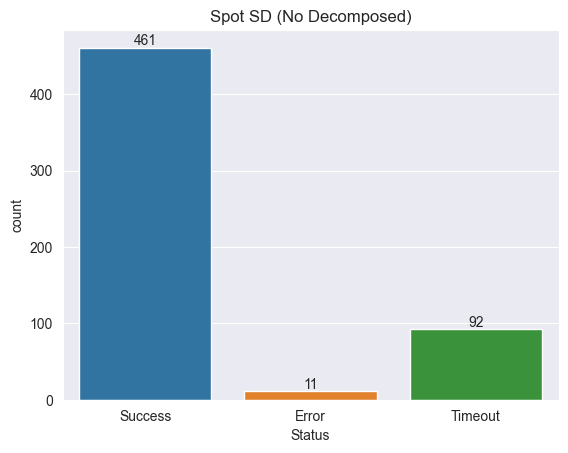

In [146]:
visual_status(spot_sd_df, "Spot SD (No Decomposed)")

# Spot SD (Decomposed)

In [147]:
spot_sd_decomposed_df = pd.DataFrame([
    spot_benchmark_loader(SPOT_SD_DECOMPOSED_SYNTHESIS_PATH, name)
    for name in get_all_benchmarks(SPOT_SD_DECOMPOSED_SYNTHESIS_PATH)
])
spot_sd_decomposed_df.sort_values(by=['Name'], ascending=True, inplace=True)
spot_sd_decomposed_df.set_index("id", inplace=True)
spot_sd_decomposed_df

,Name,Status,Is Completed,Error,Total Duration,Realizability
id,,,,,,
492,01,Success,True,None,17.0,REALIZABLE
482,02,Error,False,ltlsynt: alternate_players(): Odd cycle detected.,59.0,UNKNOWN
481,03,Error,False,ltlsynt: alternate_players(): Odd cycle detected.,1881.0,UNKNOWN
484,05,Timeout,False,None,900005.0,UNKNOWN
490,06,Error,False,ltlsynt: Too many acceptance sets used. The l...,169.0,UNKNOWN
...,...,...,...,...,...,...
425,test_f3987563_1,Success,True,None,12.0,REALIZABLE
426,test_f3987563_2,Success,True,None,11.0,REALIZABLE
290,tmp_13cfc6f2,Success,True,None,133.0,REALIZABLE


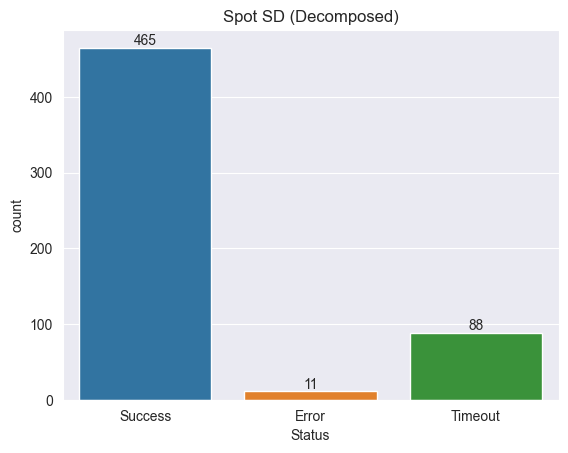

In [148]:
visual_status(spot_sd_decomposed_df, "Spot SD (Decomposed)")

# DepSynt

In [165]:
dependents_synthesis_df = load_benchmarks_df(DEPS_SYNTHESIS_PATH)
dependents_synthesis_df

,Name,Status,Is Completed,Error,Total Output Vars,Total Input Vars,Output Vars,Input Vars,Total Duration,Is Automaton Built,...,Find Dependency Duration,Find Dependency Completed,Total Compatible Pair States,Find Compatible Pair States Duration,Realizability,Synthesis Duration,Independent Synthesis Duration,Dependent Synthesis Duration,Merge Duration,Model Checking Status
id,,,,,,,,,,,,,,,,,,,,,
492,01,Success,True,NaN,3.0,4.0,"[y2, y1, y0]","[x3, x2, x1, x0]",9.0,True,...,0.0,True,55.0,0.0,REALIZABLE,2.0,2.0,0.0,NaN,UNKNOWN
482,02,Success,True,NaN,4.0,4.0,"[y3, y2, y1, y0]","[x3, x2, x1, x0]",76.0,True,...,3.0,True,572.0,2.0,REALIZABLE,55.0,55.0,0.0,NaN,UNKNOWN
481,03,Success,True,NaN,5.0,5.0,"[y4, y3, y2, y1, y0]","[x4, x3, x2, x1, x0]",1829.0,True,...,49.0,True,5371.0,49.0,REALIZABLE,1706.0,1706.0,0.0,NaN,UNKNOWN
484,05,Timeout,False,None,5.0,5.0,"[y4, y3, y2, y1, y0]","[x4, x3, x2, x1, x0]",899988.0,True,...,6001.0,False,7394.0,6000.0,NaN,NaN,NaN,NaN,NaN,NaN
490,06,Error,NaN,Runtime error: Too many acceptance sets used. ...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425,test_f3987563_1,Success,True,NaN,2.0,2.0,"[u0out0f1db1b, u0out0out]","[p0b0c, p0b0a]",133.0,True,...,0.0,True,13.0,0.0,REALIZABLE,1.0,1.0,0.0,129.0,UNKNOWN
426,test_f3987563_2,Success,True,NaN,2.0,2.0,"[u0out250f1dfun0p1db0a1b1b, u0out250out25]","[p0b0c, p0b0a]",146.0,True,...,0.0,True,9.0,0.0,REALIZABLE,1.0,1.0,0.0,142.0,UNKNOWN
290,tmp_13cfc6f2,Success,True,NaN,7.0,6.0,"[u0shutter26ctrl0f1ddo26stop1b, u0shutter26ctr...","[p0p0is26open0shutter26input, p0p0is26closed0s...",596.0,True,...,49.0,True,382.0,4.0,REALIZABLE,164.0,159.0,5.0,353.0,UNKNOWN


In [150]:
dependents_synthesis_df[dependents_synthesis_df['Status'] == Status.TIMEOUT]

,Name,Status,Is Completed,Error,Total Output Vars,Total Input Vars,Output Vars,Input Vars,Total Duration,Is Automaton Built,...,Find Dependency Duration,Find Dependency Completed,Total Compatible Pair States,Find Compatible Pair States Duration,Realizability,Synthesis Duration,Independent Synthesis Duration,Dependent Synthesis Duration,Merge Duration,Model Checking Status
id,,,,,,,,,,,,,,,,,,,,,
484,05,Timeout,False,None,5.0,5.0,"[y4, y3, y2, y1, y0]","[x4, x3, x2, x1, x0]",899988.0,True,...,6001.0,False,7394.0,6000.0,NaN,NaN,NaN,NaN,NaN,NaN
272,Alarm_06e9cad4,Timeout,False,None,6.0,14.0,[u02shades29ctrl0f1d2shades29move2to0f1d2shade...,[p0p02time29between0p1db02time29pm71b02time29p...,899992.0,True,...,47.0,True,531.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN
346,Alarm_68c86764,Timeout,False,None,6.0,11.0,[u02shades29ctrl0f1d2shades29move2to0f1d2shade...,"[p0p02time29between02time29pm702time29pm8, p0p...",899992.0,True,...,34.0,True,435.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN
319,Alarm_70523fbe,Timeout,False,None,6.0,11.0,[u02shades29ctrl0f1d2shades29move2to0f1d2shade...,"[p0p02time29between02time29pm702time29pm8, p0p...",899991.0,True,...,35.0,True,379.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN
197,Alarm_a5f99bc6,Timeout,False,None,6.0,14.0,"[u0alarm29control0f1dturn2off1b, u0alarm29cont...","[p0p0between0t29pm70t29pm8, p0p0between0t29am5...",899992.0,True,...,63.0,True,407.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,generalized_buffer,Timeout,False,None,4.0,4.0,"[b2r_req_0, b2r_req_1, b2s_ack_0, b2s_ack_1]","[r2b_ack_0, r2b_ack_1, s2b_req_0, s2b_req_1]",899993.0,True,...,6010.0,False,96282.0,6010.0,NaN,NaN,NaN,NaN,NaN,NaN
254,jarvis_philippe_484face8,Timeout,False,None,48.0,33.0,"[u0cleaning2robot0f1dclean1b, u0cleaning2robot...","[p0p0lt0temperature0value, p0p0lt0temeprature0...",899991.0,False,...,-1.0,True,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
504,ltl2dpa22,Timeout,False,None,3.0,6.0,"[p2, p1, p0]","[b, a5, a4, a3, a2, a1]",899993.0,True,...,23.0,True,1204.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN


In [151]:
dependents_synthesis_df[dependents_synthesis_df['Status'] == Status.ERROR]

,Name,Status,Is Completed,Error,Total Output Vars,Total Input Vars,Output Vars,Input Vars,Total Duration,Is Automaton Built,...,Find Dependency Duration,Find Dependency Completed,Total Compatible Pair States,Find Compatible Pair States Duration,Realizability,Synthesis Duration,Independent Synthesis Duration,Dependent Synthesis Duration,Merge Duration,Model Checking Status
id,,,,,,,,,,,,,,,,,,,,,
490,06,Error,NaN,Runtime error: Too many acceptance sets used. ...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
489,07,Error,NaN,Runtime error: Too many acceptance sets used. ...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
487,08,Error,NaN,Runtime error: Too many acceptance sets used. ...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
483,09,Error,NaN,Runtime error: Too many acceptance sets used. ...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
491,10,Error,NaN,Runtime error: Too many acceptance sets used. ...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
488,11,Error,NaN,Runtime error: Too many acceptance sets used. ...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
486,12,Error,NaN,Runtime error: Too many acceptance sets used. ...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
485,13,Error,NaN,Runtime error: Too many acceptance sets used. ...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
187,lilydemo18,Error,NaN,Runtime error: Too many acceptance sets used. ...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


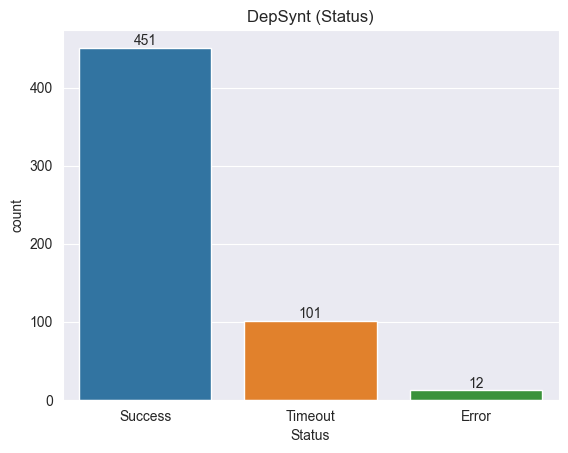

In [152]:
visual_status(dependents_synthesis_df, "DepSynt (Status)")

# Spot-Modular

In [153]:
spot_modular_synthesis_df = load_benchmarks_df(PLAIN_SYNTHESIS_PATH)
spot_modular_synthesis_df

,Name,Status,Is Completed,Error,Total Output Vars,Total Input Vars,Output Vars,Input Vars,Total Duration,Is Automaton Built,...,Find Dependency Duration,Find Dependency Completed,Total Compatible Pair States,Find Compatible Pair States Duration,Realizability,Synthesis Duration,Independent Synthesis Duration,Dependent Synthesis Duration,Merge Duration,Model Checking Status
id,,,,,,,,,,,,,,,,,,,,,
492,01,Success,True,NaN,3.0,4.0,"[y2, y1, y0]","[x3, x2, x1, x0]",9.0,True,...,-1.0,True,-1.0,NaN,REALIZABLE,2.0,2.0,0.0,NaN,UNKNOWN
482,02,Success,True,NaN,4.0,4.0,"[y3, y2, y1, y0]","[x3, x2, x1, x0]",63.0,True,...,-1.0,True,-1.0,NaN,REALIZABLE,46.0,46.0,0.0,NaN,UNKNOWN
481,03,Success,True,NaN,5.0,5.0,"[y4, y3, y2, y1, y0]","[x4, x3, x2, x1, x0]",1975.0,True,...,-1.0,False,-1.0,NaN,REALIZABLE,1890.0,1890.0,0.0,NaN,UNKNOWN
484,05,Timeout,False,None,5.0,5.0,"[y4, y3, y2, y1, y0]","[x4, x3, x2, x1, x0]",899989.0,True,...,-1.0,False,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
490,06,Error,NaN,Runtime error: Too many acceptance sets used. ...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425,test_f3987563_1,Success,True,NaN,2.0,2.0,"[u0out0f1db1b, u0out0out]","[p0b0c, p0b0a]",3.0,True,...,-1.0,False,-1.0,NaN,REALIZABLE,1.0,1.0,0.0,NaN,UNKNOWN
426,test_f3987563_2,Success,True,NaN,2.0,2.0,"[u0out250f1dfun0p1db0a1b1b, u0out250out25]","[p0b0c, p0b0a]",3.0,True,...,-1.0,False,-1.0,NaN,REALIZABLE,1.0,1.0,0.0,NaN,UNKNOWN
290,tmp_13cfc6f2,Success,True,NaN,7.0,6.0,"[u0shutter26ctrl0f1ddo26stop1b, u0shutter26ctr...","[p0p0is26open0shutter26input, p0p0is26closed0s...",184.0,True,...,-1.0,True,-1.0,NaN,REALIZABLE,162.0,162.0,0.0,NaN,UNKNOWN


In [154]:
spot_modular_synthesis_df[spot_modular_synthesis_df['Status'] == Status.TIMEOUT]

,Name,Status,Is Completed,Error,Total Output Vars,Total Input Vars,Output Vars,Input Vars,Total Duration,Is Automaton Built,...,Find Dependency Duration,Find Dependency Completed,Total Compatible Pair States,Find Compatible Pair States Duration,Realizability,Synthesis Duration,Independent Synthesis Duration,Dependent Synthesis Duration,Merge Duration,Model Checking Status
id,,,,,,,,,,,,,,,,,,,,,
484,05,Timeout,False,None,5.0,5.0,"[y4, y3, y2, y1, y0]","[x4, x3, x2, x1, x0]",899989.0,True,...,-1.0,False,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
272,Alarm_06e9cad4,Timeout,False,None,6.0,14.0,[u02shades29ctrl0f1d2shades29move2to0f1d2shade...,[p0p02time29between0p1db02time29pm71b02time29p...,899994.0,True,...,-1.0,True,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
346,Alarm_68c86764,Timeout,False,None,6.0,11.0,[u02shades29ctrl0f1d2shades29move2to0f1d2shade...,"[p0p02time29between02time29pm702time29pm8, p0p...",899993.0,True,...,-1.0,True,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
319,Alarm_70523fbe,Timeout,False,None,6.0,11.0,[u02shades29ctrl0f1d2shades29move2to0f1d2shade...,"[p0p02time29between02time29pm702time29pm8, p0p...",899992.0,True,...,-1.0,True,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197,Alarm_a5f99bc6,Timeout,False,None,6.0,14.0,"[u0alarm29control0f1dturn2off1b, u0alarm29cont...","[p0p0between0t29pm70t29pm8, p0p0between0t29am5...",899993.0,True,...,-1.0,True,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,generalized_buffer,Timeout,False,None,4.0,4.0,"[b2r_req_0, b2r_req_1, b2s_ack_0, b2s_ack_1]","[r2b_ack_0, r2b_ack_1, s2b_req_0, s2b_req_1]",899991.0,True,...,-1.0,True,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
254,jarvis_philippe_484face8,Timeout,False,None,48.0,33.0,"[u0cleaning2robot0f1dclean1b, u0cleaning2robot...","[p0p0lt0temperature0value, p0p0lt0temeprature0...",899992.0,False,...,-1.0,True,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
504,ltl2dpa22,Timeout,False,None,3.0,6.0,"[p2, p1, p0]","[b, a5, a4, a3, a2, a1]",899993.0,True,...,-1.0,False,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [155]:
spot_modular_synthesis_df[spot_modular_synthesis_df['Status'] == Status.ERROR]

,Name,Status,Is Completed,Error,Total Output Vars,Total Input Vars,Output Vars,Input Vars,Total Duration,Is Automaton Built,...,Find Dependency Duration,Find Dependency Completed,Total Compatible Pair States,Find Compatible Pair States Duration,Realizability,Synthesis Duration,Independent Synthesis Duration,Dependent Synthesis Duration,Merge Duration,Model Checking Status
id,,,,,,,,,,,,,,,,,,,,,
490,06,Error,NaN,Runtime error: Too many acceptance sets used. ...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
489,07,Error,NaN,Runtime error: Too many acceptance sets used. ...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
487,08,Error,NaN,Runtime error: Too many acceptance sets used. ...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
483,09,Error,NaN,Runtime error: Too many acceptance sets used. ...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
491,10,Error,NaN,Runtime error: Too many acceptance sets used. ...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
488,11,Error,NaN,Runtime error: Too many acceptance sets used. ...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
486,12,Error,NaN,Runtime error: Too many acceptance sets used. ...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
485,13,Error,NaN,Runtime error: Too many acceptance sets used. ...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
187,lilydemo18,Error,NaN,Runtime error: Too many acceptance sets used. ...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


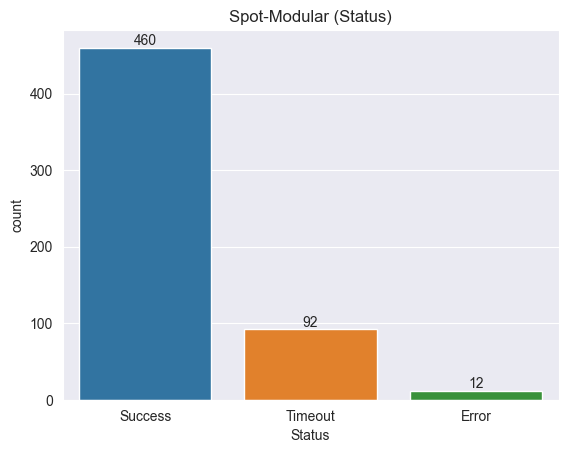

In [156]:
visual_status(spot_modular_synthesis_df, "Spot-Modular (Status)")

# Dependency Synthesis (With Model Checking)


In [157]:
deps_synt_model_checking_df = load_benchmarks_df(DEPS_SYNTHESIS_MODEL_CHECKING_PATH)
deps_synt_model_checking_df

,Name,Status,Is Completed,Error,Total Output Vars,Total Input Vars,Output Vars,Input Vars,Total Duration,Is Automaton Built,...,Find Dependency Duration,Find Dependency Completed,Total Compatible Pair States,Find Compatible Pair States Duration,Realizability,Synthesis Duration,Independent Synthesis Duration,Dependent Synthesis Duration,Merge Duration,Model Checking Status
id,,,,,,,,,,,,,,,,,,,,,
492,01,Success,True,NaN,3.0,4.0,"[y2, y1, y0]","[x3, x2, x1, x0]",14.0,True,...,0.0,True,55.0,0.0,REALIZABLE,2.0,2.0,0.0,NaN,OK
482,02,Success,True,NaN,4.0,4.0,"[y3, y2, y1, y0]","[x3, x2, x1, x0]",115.0,True,...,2.0,True,572.0,2.0,REALIZABLE,48.0,48.0,0.0,NaN,OK
481,03,Success,True,NaN,5.0,5.0,"[y4, y3, y2, y1, y0]","[x4, x3, x2, x1, x0]",6435.0,True,...,60.0,True,5371.0,60.0,REALIZABLE,2099.0,2099.0,0.0,NaN,OK
484,05,Success,True,NaN,5.0,5.0,"[y4, y3, y2, y1, y0]","[x4, x3, x2, x1, x0]",1542460.0,True,...,6000.0,False,8336.0,6000.0,REALIZABLE,1519180.0,1519180.0,0.0,NaN,OK
490,06,Error,NaN,Runtime error: Too many acceptance sets used. ...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425,test_f3987563_1,Success,True,NaN,2.0,2.0,"[u0out0f1db1b, u0out0out]","[p0b0c, p0b0a]",129.0,True,...,0.0,True,13.0,0.0,REALIZABLE,1.0,1.0,0.0,124.0,OK
426,test_f3987563_2,Success,True,NaN,2.0,2.0,"[u0out250f1dfun0p1db0a1b1b, u0out250out25]","[p0b0c, p0b0a]",112.0,True,...,0.0,True,9.0,0.0,REALIZABLE,1.0,1.0,0.0,107.0,OK
290,tmp_13cfc6f2,Error,NaN,Hierarchy reader flattened 2 instances of logi...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [158]:
deps_synt_model_checking_df[deps_synt_model_checking_df['Status'] == Status.TIMEOUT]

,Name,Status,Is Completed,Error,Total Output Vars,Total Input Vars,Output Vars,Input Vars,Total Duration,Is Automaton Built,...,Find Dependency Duration,Find Dependency Completed,Total Compatible Pair States,Find Compatible Pair States Duration,Realizability,Synthesis Duration,Independent Synthesis Duration,Dependent Synthesis Duration,Merge Duration,Model Checking Status
id,,,,,,,,,,,,,,,,,,,,,
272,Alarm_06e9cad4,Timeout,False,None,6.0,14.0,[u02shades29ctrl0f1d2shades29move2to0f1d2shade...,[p0p02time29between0p1db02time29pm71b02time29p...,3599992.0,True,...,34.0,True,531.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN
346,Alarm_68c86764,Timeout,False,None,6.0,11.0,[u02shades29ctrl0f1d2shades29move2to0f1d2shade...,"[p0p02time29between02time29pm702time29pm8, p0p...",3599992.0,True,...,39.0,True,435.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN
319,Alarm_70523fbe,Timeout,False,None,6.0,11.0,[u02shades29ctrl0f1d2shades29move2to0f1d2shade...,"[p0p02time29between02time29pm702time29pm8, p0p...",3599995.0,True,...,33.0,True,379.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN
197,Alarm_a5f99bc6,Timeout,False,None,6.0,14.0,"[u0alarm29control0f1dturn2off1b, u0alarm29cont...","[p0p0between0t29pm70t29pm8, p0p0between0t29am5...",3599996.0,True,...,47.0,True,407.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN
253,Alarm_f2774e0b,Timeout,False,None,6.0,10.0,[u02shades29ctrl0f1d2shades29move2to0f1d2shade...,"[p0p02time29between02time29pm702time29pm8, p0p...",3599992.0,True,...,33.0,True,351.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
559,detector_unreal,Timeout,False,None,1.0,10.0,[g],"[r_0, r_1, r_2, r_3, r_4, r_5, r_6, r_7, r_8, ...",3599994.0,True,...,2.0,True,528.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
157,full_arbiter_enc,Timeout,False,None,4.0,3.0,"[grant_0, grant_1, grant_2, grant_3]","[request_0, request_1, request_2]",3599992.0,True,...,6000.0,False,9061.0,6000.0,NaN,NaN,NaN,NaN,NaN,NaN
158,generalized_buffer,Timeout,False,None,4.0,4.0,"[b2r_req_0, b2r_req_1, b2s_ack_0, b2s_ack_1]","[r2b_ack_0, r2b_ack_1, s2b_req_0, s2b_req_1]",3599992.0,True,...,6011.0,False,96245.0,6011.0,NaN,NaN,NaN,NaN,NaN,NaN


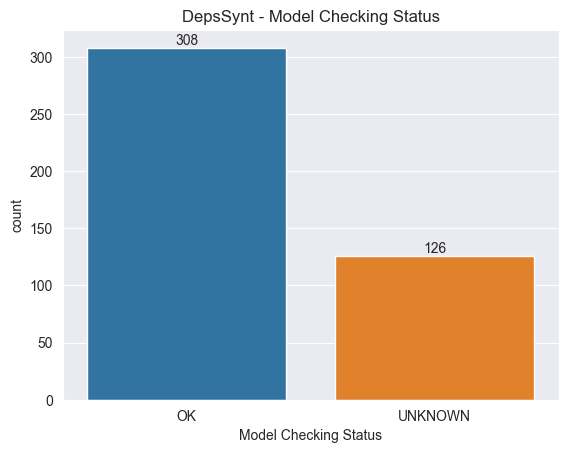

In [159]:
ax = sns.countplot(data=deps_synt_model_checking_df, x='Model Checking Status')
ax.bar_label(ax.containers[0]);
ax.set_title("DepsSynt - Model Checking Status");

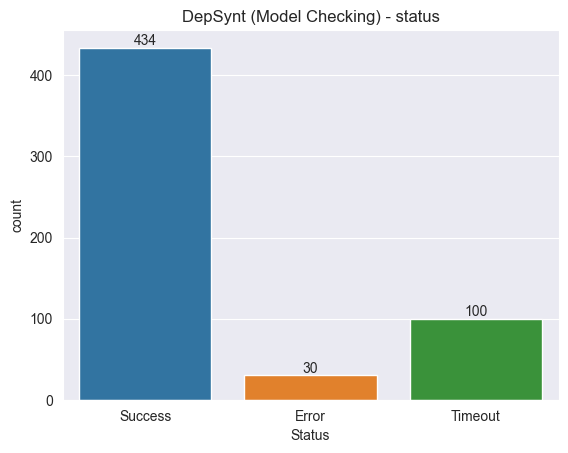

In [160]:
visual_status(deps_synt_model_checking_df, "DepSynt (Model Checking) - status")

# Sanity Check

## All Tools have same realizability

In [161]:
common_realizability = pd.merge(
    pd.merge(
        spot_sd_df[['Name', 'Realizability']],
        spot_sd_decomposed_df[['Name', 'Realizability']],
        on='Name',
        suffixes=('_sd', '_sd_decomposed'),
    ),
    pd.merge(
        dependents_synthesis_df[['Name', 'Realizability']],
        spot_modular_synthesis_df[['Name', 'Realizability']],
        on='Name',
        suffixes=('_depsynt', '_spot_modular')
    ),
    on='Name'
)
# How many different rows
common_realizability['opposite_realizability'] = common_realizability.apply(lambda row: ('REALIZABLE' in row.values) and ('UNREALIZABLE' in row.values), axis=1)

common_realizability[common_realizability['opposite_realizability'] == True]

,Name,Realizability_sd,Realizability_sd_decomposed,Realizability_depsynt,Realizability_spot_modular,opposite_realizability


## Find Deps Timeout

In [162]:
dependents_synthesis_df["Find Dependency Duration"]

id
492       0.0
482       3.0
481      49.0
484    6001.0
490       NaN
        ...  
425       0.0
426       0.0
290      49.0
435       0.0
436       4.0
Name: Find Dependency Duration, Length: 564, dtype: float64

### DepSynt, Spot-Modular, Spot-SD (Decomposed) have same benchmarks

In [163]:
missing_ids = dependents_synthesis_df[~dependents_synthesis_df['Name'].isin(spot_modular_synthesis_df['Name'])]
missing_ids

,Name,Status,Is Completed,Error,Total Output Vars,Total Input Vars,Output Vars,Input Vars,Total Duration,Is Automaton Built,...,Find Dependency Duration,Find Dependency Completed,Total Compatible Pair States,Find Compatible Pair States Duration,Realizability,Synthesis Duration,Independent Synthesis Duration,Dependent Synthesis Duration,Merge Duration,Model Checking Status
id,,,,,,,,,,,,,,,,,,,,,


In [164]:
missing_ids = spot_modular_synthesis_df[~spot_modular_synthesis_df['Name'].isin(dependents_synthesis_df['Name'])]
missing_ids

,Name,Status,Is Completed,Error,Total Output Vars,Total Input Vars,Output Vars,Input Vars,Total Duration,Is Automaton Built,...,Find Dependency Duration,Find Dependency Completed,Total Compatible Pair States,Find Compatible Pair States Duration,Realizability,Synthesis Duration,Independent Synthesis Duration,Dependent Synthesis Duration,Merge Duration,Model Checking Status
id,,,,,,,,,,,,,,,,,,,,,
